In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

Double Q-learning

Initial Q1 Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Initial Q2 Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q1 Table:
[[ 1.89225188e+00  8.71297979e+00  1.87076346e+01  1.17116828e+01]
 [ 3.89599702e+00  1.26464992e+01  2.30517144e+01  7.73358501e+00]
 [-3.39341055e+00  2.19962497e+01  2.14058940e+01  1.0025191

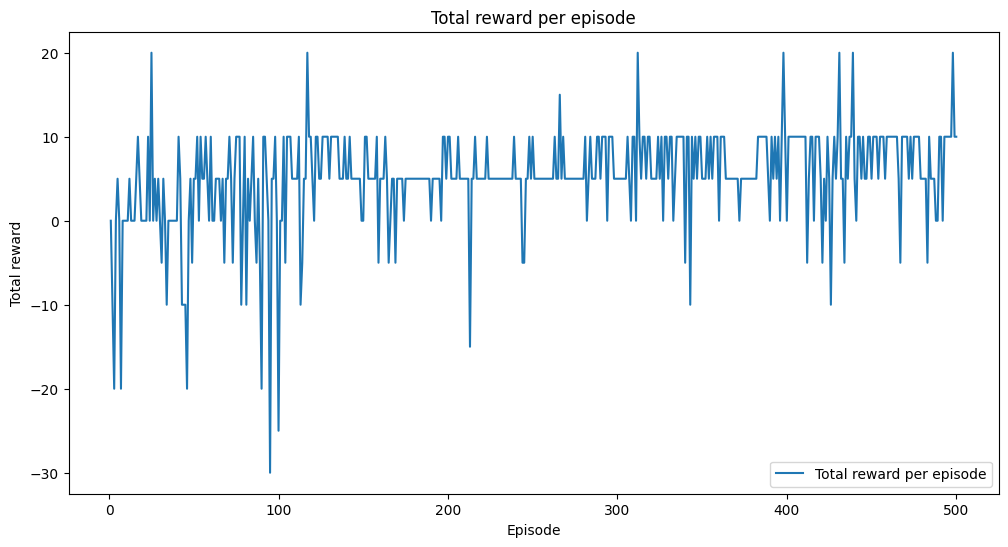

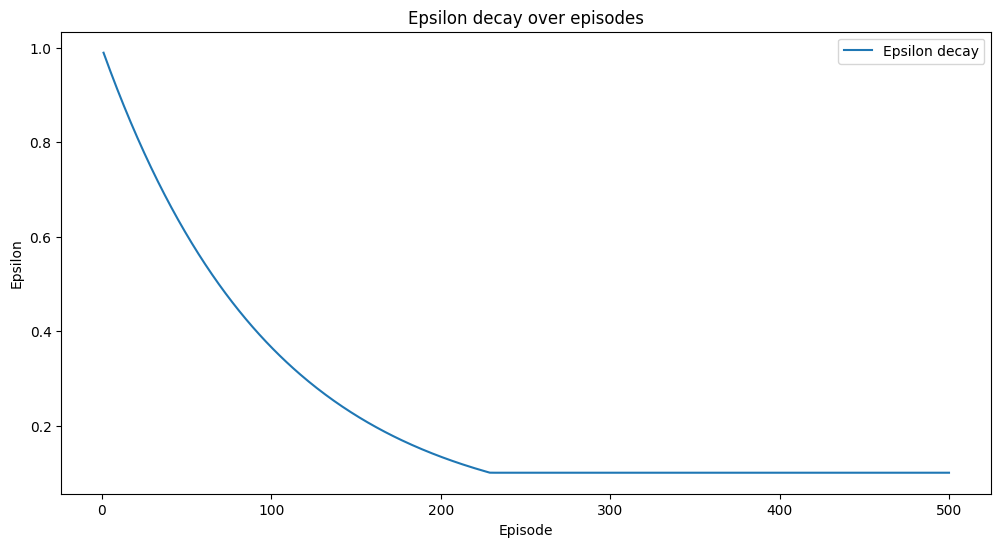

In [2]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20  
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        
        self.rewards[0, 2] = 5  
        self.rewards[4, 2] = 10 

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1 
        grid[self.rewards == 20] = 2 
        grid[self.rewards == -10] = 3 

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]


def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])


def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()


env = FireFightersOperation()
initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(env)

print("Initial Q1 Table:")
print(initial_Q1)
print("Initial Q2 Table:")
print(initial_Q2)

print("Trained Q1 Table:")
print(Q1)
print("Trained Q2 Table:")
print(Q2)

plot_results(total_rewards, epsilon_values)


Hyperparameter tuning

Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, n=20
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, n=20
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=5
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=10
Training with alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, n=20
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=5
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=10
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.99, n=20
Training with alpha=0.1, gamma=0.9, epsilon=0.8, epsilon_decay=0.995, n=5
Training with alpha=0.1, gamma=0.9, 

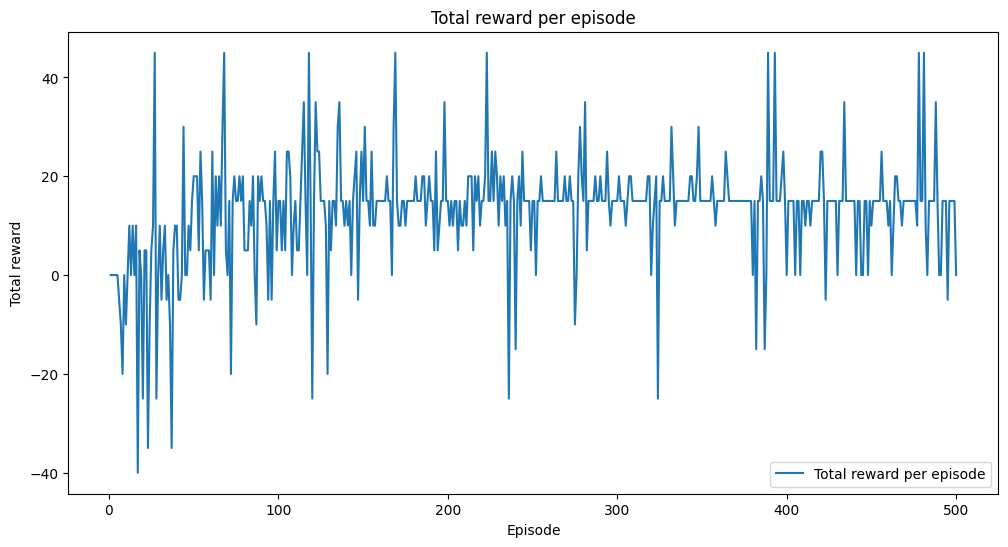

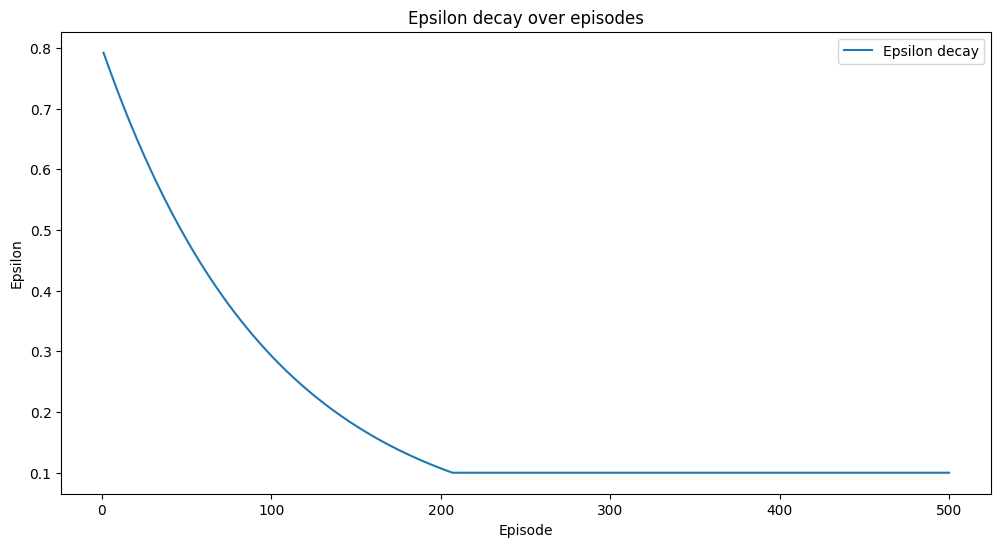

In [3]:
import itertools

class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20 
        self.rewards[1, 2] = -10  
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.rewards[0, 2] = 5  
        self.rewards[4, 2] = 10  

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  
        grid[self.rewards == 20] = 2
        grid[self.rewards == -10] = 3 

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values


#Hyperparameter tuning using Grid Search
def tune_hyperparameters(env):
    alpha_values = [0.1, 0.01, 0.001]
    gamma_values = [0.9, 0.95, 0.99]
    epsilon_values = [1.0, 0.8, 0.5]
    epsilon_decay_values = [0.99, 0.995, 0.999]
    n_values = [5, 10, 20]

    param_grid = itertools.product(alpha_values, gamma_values, epsilon_values, epsilon_decay_values, n_values)

    results = []

    for params in param_grid:
        alpha, gamma, epsilon, epsilon_decay, n = params
        print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, n={n}")

        initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_history = double_q_learning_n_step(
            env,
            episodes=500,
            n=n,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            epsilon_decay=epsilon_decay,
            min_epsilon=0.1
        )

        avg_reward = np.mean(total_rewards[-100:])
        results.append((params, avg_reward))

    best_params, best_reward = max(results, key=lambda x: x[1])
    print(f"Best hyperparameters: {best_params} with average reward: {best_reward}")
    return best_params


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()


env = FireFightersOperation()
best_params = tune_hyperparameters(env)

alpha, gamma, epsilon, epsilon_decay, n = best_params
initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(
    env,
    episodes=500,
    n=n,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=0.1
)

print("Initial Q1 Table:")
print(initial_Q1)
print("Initial Q2 Table:")
print(initial_Q2)

print("Trained Q1 Table:")
print(Q1)
print("Trained Q2 Table:")
print(Q2)

# Plot results
plot_results(total_rewards, epsilon_values)


n-step Q-learning

Running Double Q-Learning with n=1


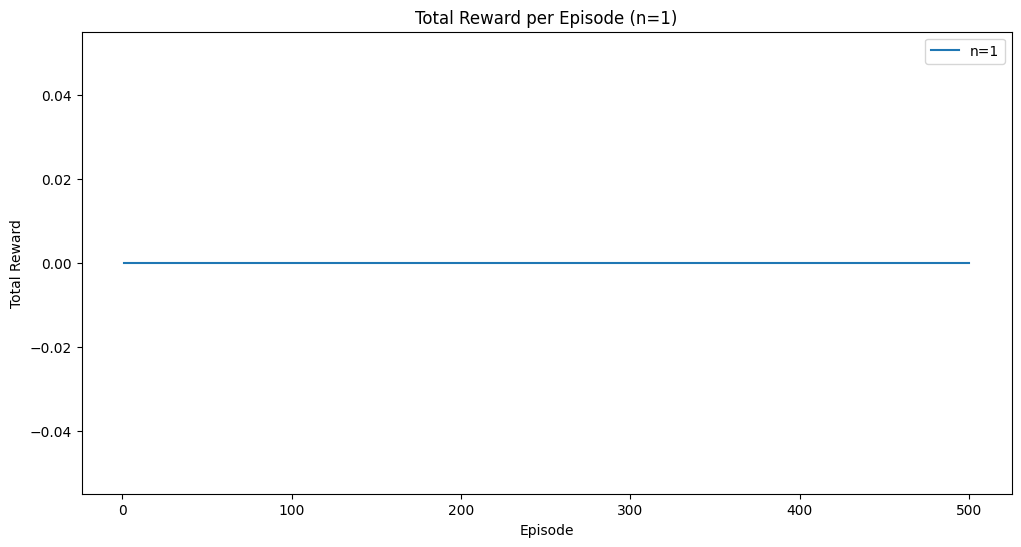

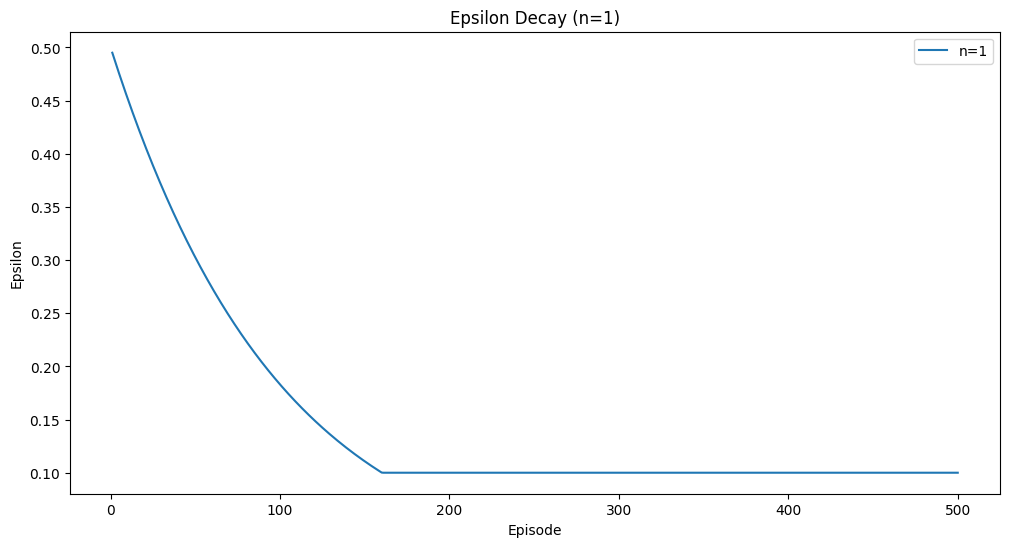

Running Double Q-Learning with n=2


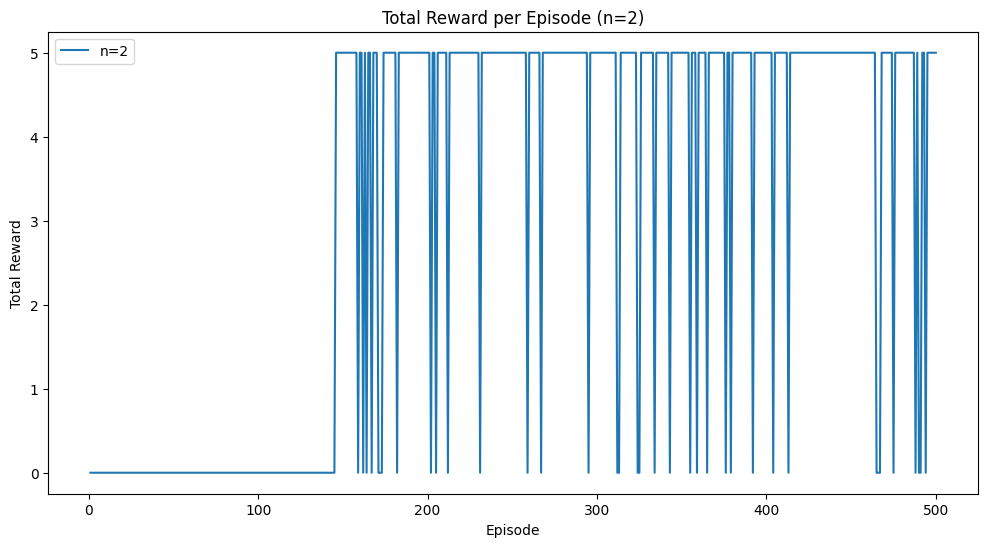

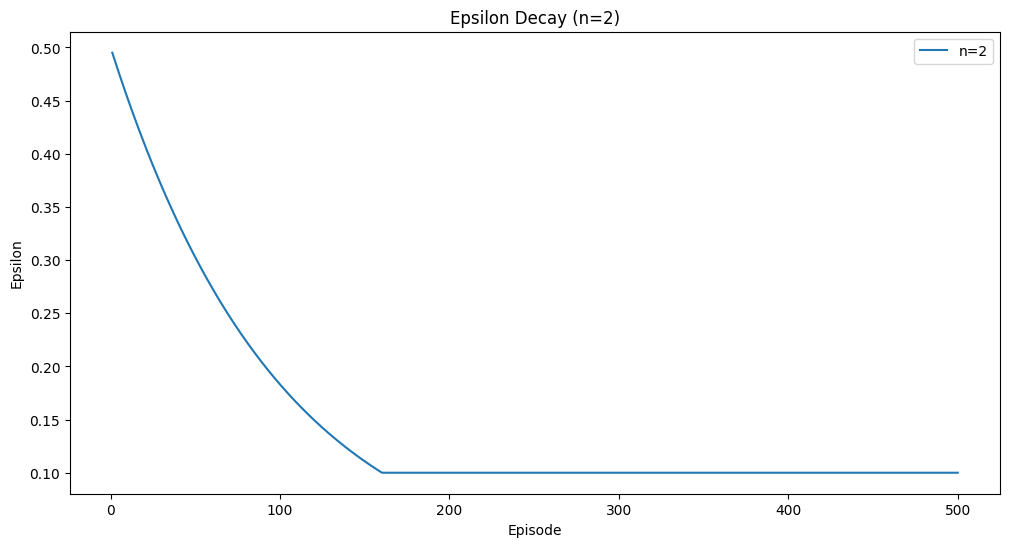

Running Double Q-Learning with n=3


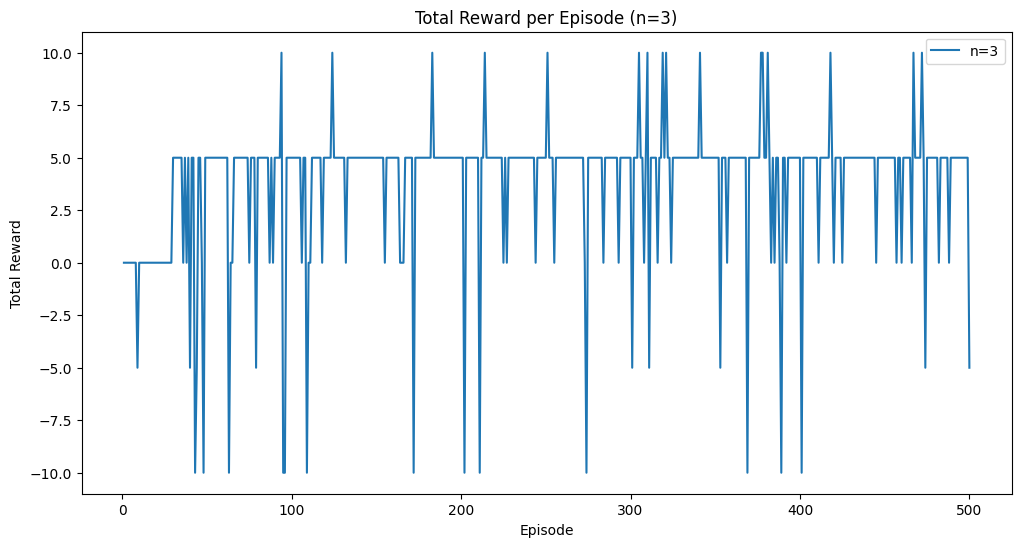

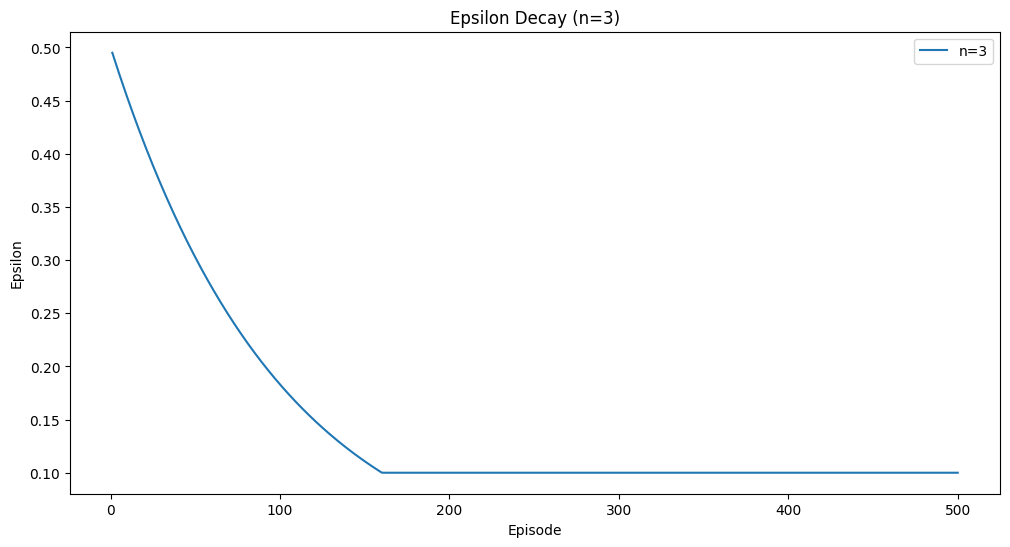

Running Double Q-Learning with n=4


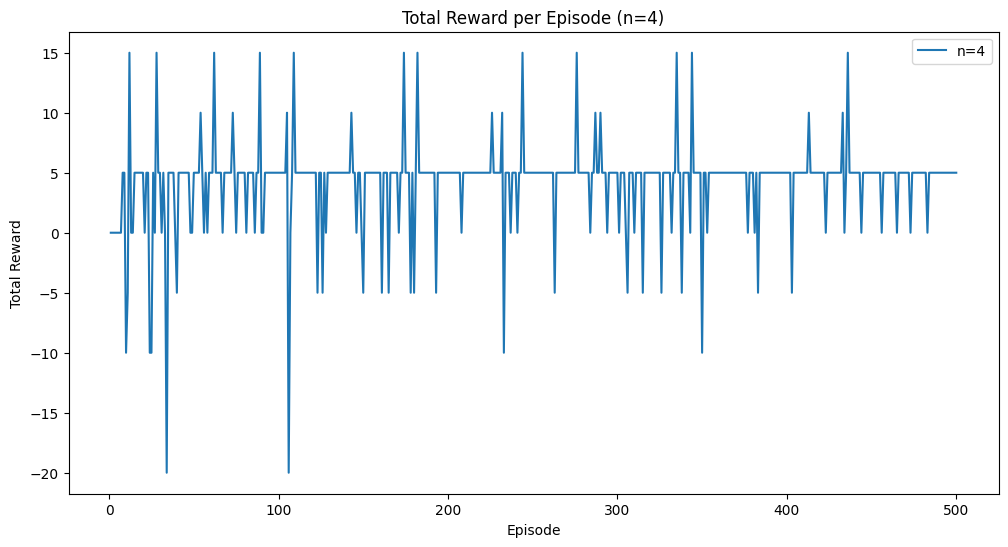

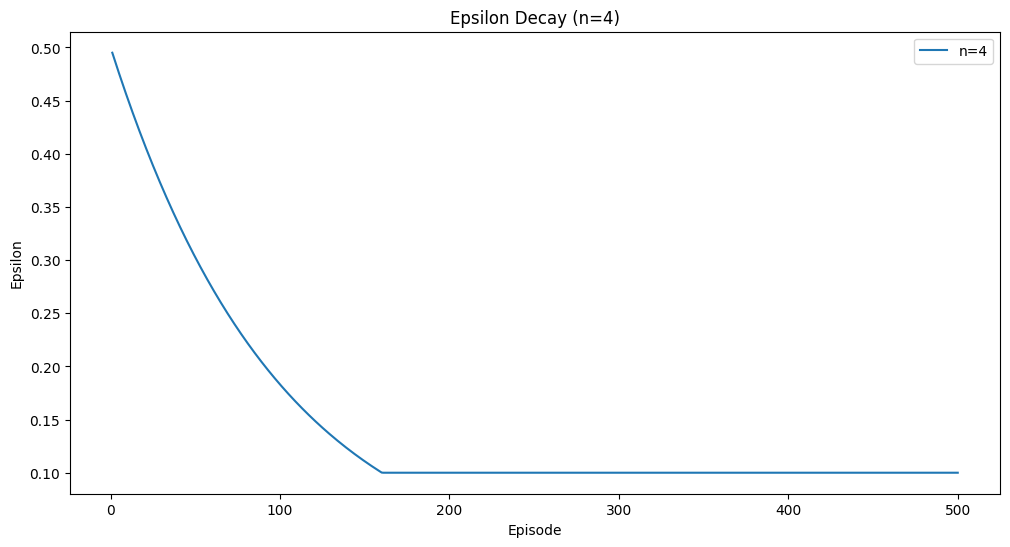

Running Double Q-Learning with n=5


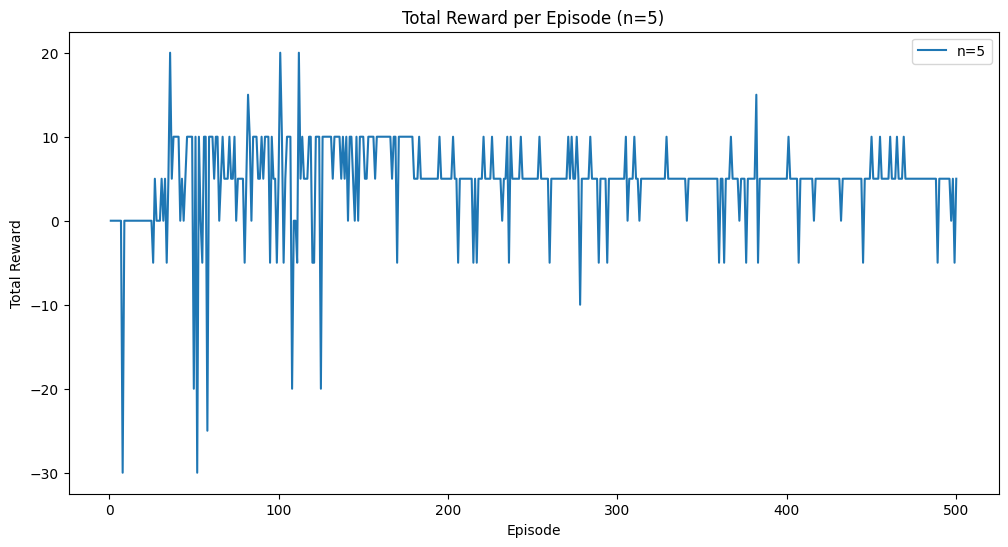

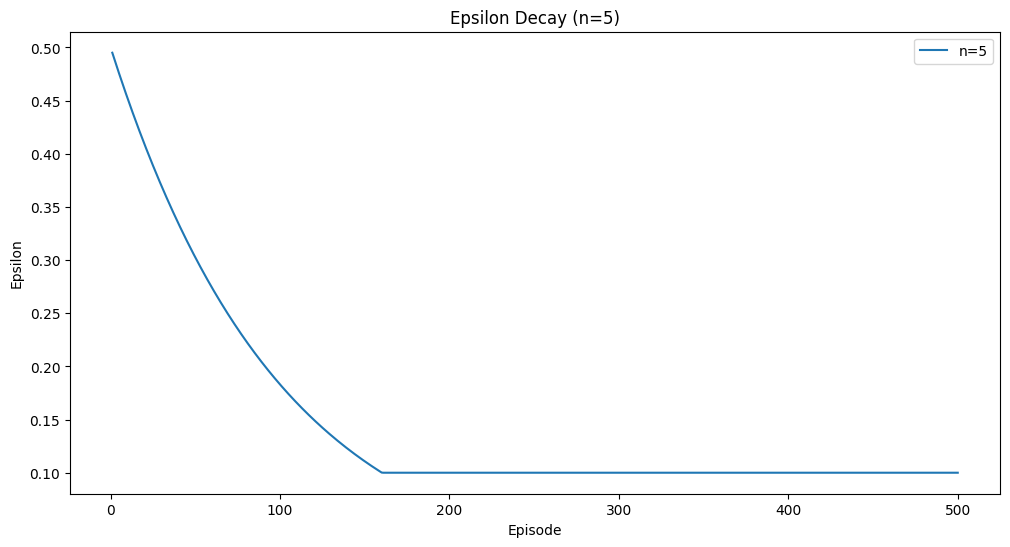

Evaluating greedy performance for n=1
Total reward for 10 episodes with greedy actions (n=1): 0.0
Evaluating greedy performance for n=2
Total reward for 10 episodes with greedy actions (n=2): 25.0
Evaluating greedy performance for n=3
Total reward for 10 episodes with greedy actions (n=3): 45.0
Evaluating greedy performance for n=4
Total reward for 10 episodes with greedy actions (n=4): 45.0
Evaluating greedy performance for n=5
Total reward for 10 episodes with greedy actions (n=5): 25.0


In [4]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20 
        self.rewards[1, 2] = -10 
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.rewards[0, 2] = 5 
        self.rewards[4, 2] = 10

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  #down
            self.firefighter_position[0] += 1
        elif action == 1:  #up
            self.firefighter_position[0] -= 1
        elif action == 2:  #right
            self.firefighter_position[1] += 1
        elif action == 3:  #left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1 
        grid[self.rewards == 20] = 2 
        grid[self.rewards == -10] = 3  

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def double_q_learning_n_step(env, episodes=500, n=5, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q1, state, epsilon, env.action_space.n)
        rewards = 0
        trajectory = []

        for t in range(n):
            next_state, reward, terminated, _, _ = env.step(action)
            trajectory.append((state, action, reward, next_state))
            state, action = next_state, epsilon_greedy(Q1, state, epsilon, env.action_space.n)
            rewards += reward
            if terminated:
                break

        for step in reversed(range(len(trajectory))):
            state, action, reward, next_state = trajectory[step]

            if step == len(trajectory) - 1:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])
            else:
                next_action = epsilon_greedy(Q2, next_state, epsilon, env.action_space.n)
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
                next_action = epsilon_greedy(Q1, next_state, epsilon, env.action_space.n)
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(rewards)
        epsilon_values.append(epsilon)

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values

alpha = 0.01
gamma = 0.95
epsilon = 0.5
epsilon_decay = 0.99
episodes = 500
n_values = [1, 2, 3, 4, 5]

all_results = {}

for n in n_values:
    print(f"Running Double Q-Learning with n={n}")
    initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = double_q_learning_n_step(
        env,
        episodes=episodes,
        n=n,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=0.1
    )
    
    all_results[n] = {
        'initial_Q1': initial_Q1,
        'initial_Q2': initial_Q2,
        'Q1': Q1,
        'Q2': Q2,
        'total_rewards': total_rewards,
        'epsilon_values': epsilon_values
    }

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label=f'n={n}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Total Reward per Episode (n={n})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, episodes + 1), epsilon_values, label=f'n={n}')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title(f'Epsilon Decay (n={n})')
    plt.legend()
    plt.show()

for n in n_values:
    print(f"Evaluating greedy performance for n={n}")
    
    Q1 = all_results[n]['Q1']
    Q2 = all_results[n]['Q2']

    total_rewards = []
    for _ in range(10):
        state, _ = env.reset()
        rewards = 0
        terminated = False
        while not terminated:
            action = np.argmax(Q1[state] + Q2[state]) 
            next_state, reward, terminated, _, _ = env.step(action)
            rewards += reward
            state = next_state
        total_rewards.append(rewards)
    
    print(f"Total reward for 10 episodes with greedy actions (n={n}): {np.mean(total_rewards)}")

